In [15]:
import os 
#os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax 
jax.config.update("jax_enable_x64", True)
import jax_sbgeom
import jax.numpy as jnp
from jax_sbgeom.coils import CoilSet, DiscreteCoil, FiniteSizeCoilSet, RotationMinimizedFrame, mesh_coilset_surface
from jax_sbgeom.flux_surfaces import FluxSurfaceNormalExtendedNoPhi, mesh_surface, ToroidalExtent
from jax_sbgeom.flux_surfaces.flux_surfaces_utilities import generate_thickness_matrix
from jax_sbgeom.coils.coil_winding_surface import create_optimized_coil_winding_surface
%load_ext autoreload
%autoreload 2
from jax_sbgeom.jax_utils.utils import _mesh_to_pyvista_mesh
def _get_discrete_coils(coil_file):
    import h5py
    with h5py.File(coil_file, 'r') as f:
        coil_data = jnp.array(f['Dataset1'])
    return CoilSet.from_list([DiscreteCoil.from_positions(coil_data[i]) for i in range(coil_data.shape[0])])

def _get_discrete_coils_only(coil_file):
    import h5py
    with h5py.File(coil_file, 'r') as f:
        coil_data = jnp.array(f['Dataset1'])
    return [DiscreteCoil.from_positions(coil_data[i]) for i in range(coil_data.shape[0])]
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
vmec_file = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/helias3_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/helias5_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_vmec.nc4"][1]
coil_file = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS3_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS5_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_coilset.h5"][1]

In [17]:
flux_surface = jax_sbgeom.flux_surfaces.FluxSurfaceNormalExtendedNoPhi.from_hdf5(vmec_file)
coilset      = _get_discrete_coils(coil_file)

In [18]:
finite_size_coilset = FiniteSizeCoilSet.from_coilset(coilset, RotationMinimizedFrame, 100)

rmf_mesh = mesh_coilset_surface(finite_size_coilset, 300, 0.2 ,0.2 )

In [19]:
cws_mesh = create_optimized_coil_winding_surface(coilset, n_points_per_coil=200, n_points_phi = 500, surface_type = "spline")
lcfs_mesh = mesh_surface(flux_surface, 1.0, ToroidalExtent(-1, 2 * jnp.pi / 2.0), 500, 500)

In [20]:
n_poloidal_rays = 30
n_toroidal_rays = 30

theta_s = jnp.linspace(0, 2 * jnp.pi, n_poloidal_rays)
phi_s   = jnp.linspace(0, 2 * jnp.pi / flux_surface.settings.nfp, n_toroidal_rays)
theta_mg, phi_mg = jnp.meshgrid(theta_s, phi_s, indexing='ij')

LCFS = flux_surface.cartesian_position(1.0, theta_mg, phi_mg)
d_LCFS = flux_surface.cartesian_position(2.0, theta_mg, phi_mg) - LCFS

In [21]:
discrete_coils_only = _get_discrete_coils_only(coil_file)
phi_max = 2 * jnp.pi / flux_surface.settings.nfp
coil_list = []
for coil in discrete_coils_only:
    phi_centre = jnp.arctan2(coil.centre()[1], coil.centre()[0])
    if phi_centre < phi_max and phi_centre >= 0:
        coil_list.append(coil)
coilset_truncated = CoilSet.from_list(coil_list)


coilset_truncated_rmf = FiniteSizeCoilSet.from_coilset(coilset_truncated, RotationMinimizedFrame, 100)
coilset_truncated_rmf_mesh = mesh_coilset_surface(coilset_truncated_rmf, 300, 0.2 ,0.2 )

In [22]:
import pyvista as pv
plotter = pv.Plotter(window_size=[900, int(900 * 0.75)])

plotter.add_mesh(_mesh_to_pyvista_mesh(*cws_mesh), color='lightgrey', opacity=0.4, show_edges=False)
plotter.add_mesh(_mesh_to_pyvista_mesh(*rmf_mesh), color='cyan', opacity=1.0, show_edges=False)
plotter.add_mesh(_mesh_to_pyvista_mesh(*lcfs_mesh), color='lightblue', opacity=1.0, show_edges=False)


plotter.add_arrows(LCFS, d_LCFS, mag = 2.0 , color = 'red')
plotter.camera.position    = (7.920269193531761, -29.364895547441858, 13.260398034562193)
plotter.camera.focal_point = (17.252318958192408, 7.859902146409471, 1.9152626501079728)
plotter.camera.up          =  (0.015661256564529463, 0.28790403430695255, 0.9575311963965463)
plotter.show()

Widget(value='<iframe src="http://localhost:34041/index.html?ui=P_0x7194581d3a40_2&reconnect=auto" class="pyvi…

In [23]:
theta, phi, d_grid = generate_thickness_matrix(flux_surface, cws_mesh, 200, 205)

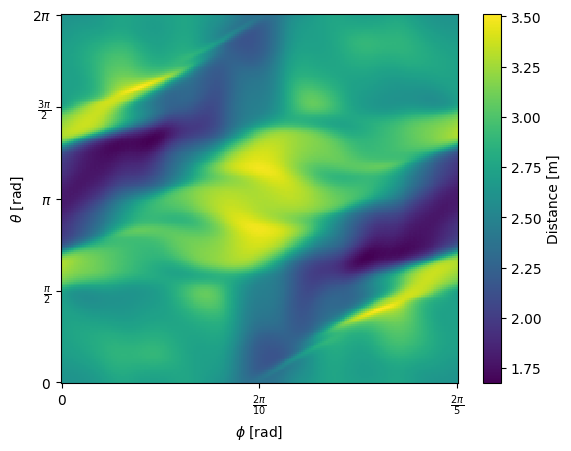

In [24]:
plt.pcolormesh(phi, theta, d_grid, shading='auto')
symm = flux_surface.settings.nfp
plt.yticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi],   [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
plt.xticks([0, 2 * jnp.pi / symm / 2,  2*jnp.pi / symm ], [r'$0$', r'$\frac{2 \pi}{%d}$' % (2 * symm), r'$\frac{2 \pi}{%d}$' % symm])
plt.xlabel(r'$\phi$ [rad]')
plt.ylabel(r'$\theta$ [rad]')
plt.colorbar(label=r'Distance [m]')

In [25]:
from jax_sbgeom.flux_surfaces.convert_to_vmec import  create_fourier_surface_extension_interp_equal_arclength, _create_fluxsurface_from_rmnc_zmns
from jax_sbgeom.flux_surfaces import FluxSurfaceFourierExtended,mesh_surfaces_closed

In [26]:
flux_surface_extension = _create_fluxsurface_from_rmnc_zmns(*create_fourier_surface_extension_interp_equal_arclength(flux_surface, d_grid, n_theta = 100, n_phi = 200, n_theta_sample_arclength = 100))
flux_surface_total     = FluxSurfaceFourierExtended.from_flux_surface_and_extension(flux_surface, flux_surface_extension)

In [30]:
mesh_blanket_cws = mesh_surfaces_closed(flux_surface_total,1.1,2.0,ToroidalExtent(0,2*jnp.pi/flux_surface.settings.nfp),60,120, 10)

In [31]:
plotter = pv.Plotter(window_size=[900, int(900 * 0.75)])

plotter.add_mesh(_mesh_to_pyvista_mesh(*mesh_blanket_cws), color="lightgreen", opacity=1.0, show_edges=  True)

plotter.add_mesh(_mesh_to_pyvista_mesh(*coilset_truncated_rmf_mesh), color='cyan', opacity=1.0, show_edges=False)

plotter.add_mesh(_mesh_to_pyvista_mesh(*lcfs_mesh), color='lightblue', opacity=1.0, show_edges=False)


plotter.camera.position = (7.920269193531761, -29.364895547441858, 13.260398034562193)
plotter.camera.focal_point = (17.252318958192408, 7.859902146409471, 1.9152626501079728)
plotter.camera.up =  (0.015661256564529463, 0.28790403430695255, 0.9575311963965463)
plotter.show()

Widget(value='<iframe src="http://localhost:34041/index.html?ui=P_0x7192c075e6c0_4&reconnect=auto" class="pyvi…